# STEMMUS_SCOPE BMI groundwater coupling
We have to choose how we want to run the BMI. We can do this either using a local executable file, or with a Docker container.

How to run the model is define in the configuration file.
If it has an entry "ExeFilePath" it will use the local executable. If this is missing, it wil try to use Docker (if docker-py is available). 

In [1]:
cfg_file = "/home/bart/tmp/stemmus_scope/config_docker.txt"
#cfg_file = "/home/bart/tmp/stemmus_scope/config_exe.txt"
# cfg_file = "/home/sarah/temp/ecoextreml/test/input/ZA-Kru_2024-07-31-1555/ZA-Kru_2024-07-31-1555_config.txt"
cfg_file = "/home/sarah/temp/ecoextreml/test/input/DE-Geb_2024-08-01-1043/DE-Geb_2024-08-01-1043_config.txt"


If we are using the local executable file we first have to add the matlab runtime compiler locations to PATH:

In [2]:
# if "exe.txt" in cfg_file:
#     from PyStemmusScope.config_io import read_config
#     import os
#     os.environ['LD_LIBRARY_PATH'] = (
#         "/home/bart/matlab_runtime/R2023a/runtime/glnxa64:"
#         "/home/bart/matlab_runtime/R2023a/bin/glnxa64:"
#         "/home/bart/matlab_runtime/R2023a/sys/os/glnxa64:"
#         "/home/bart/matlab_runtime/R2023a/extern/bin/glnxa64:"
#         "/home/bart/matlab_runtime/R2023a/sys/opengl/lib/glnxa64"
#     )
#     os.environ["STEMMUS_SCOPE"] = read_config(cfg_file)["ExeFilePath"]


from PyStemmusScope.config_io import read_config
import os
matlab_path = !whereis MATLAB
matlab_path = matlab_path.s.split(": ")[1]
os.environ['LD_LIBRARY_PATH'] = (
    f"{matlab_path}/MATLAB_Runtime/R2023a/runtime/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/bin/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/sys/os/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/extern/bin/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/sys/opengl/lib/glnxa64")
print(os.environ['LD_LIBRARY_PATH'])
os.environ["STEMMUS_SCOPE"] = read_config(cfg_file)["ExeFilePath"]

/usr/local/MATLAB/MATLAB_Runtime/R2023a/runtime/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/sys/os/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/extern/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/sys/opengl/lib/glnxa64


Now we can initialize the model with a prepared configuration file:

In [3]:
from PyStemmusScope.bmi.implementation import StemmusScopeBmi
from cftime import num2pydate
from rich import print
import numpy as np
import xarray as xr

model = StemmusScopeBmi()

model.initialize(cfg_file)

model.update()  # STEMMUS_SCOPE needs to be updated by one timestep before the BMI is accessible

After initialization we can enable the groundwater coupling. You enable this using the following command:

In [4]:
model.set_value("groundwater_coupling_enabled", np.array([True]))

To make use of the groundwater coupling routines, a few variables will need to be set:
- the elevation (above reference, e.g. Mean Sea Level) of the top of the aquifer (in cm)
- the groundwater head (above reference) in the lowest STEMMUS_SCOPE soil layer (in cm)

The groundwater height (where the hydrostatic pressure is equal to 0.0, will be at a depth of `groundwater_elevation_top_aquifer` - `groundwater_head_bottom_layer` in the STEMMUS_SCOPE model).

Lastly, a groundwater temperature can be defined. However, this is optional.

In [5]:
model.set_value("groundwater_elevation_top_aquifer", np.array([2000.]))
# model.set_value("groundwater_head_bottom_layer", np.array([2000-250.]))  # 250 cm under ground surface
model.set_value("groundwater_head_bottom_layer", np.array([1950.]))  # 50 cm under ground surface

model.set_value("groundwater_temperature", np.array([23.])) # optional. 50 deg C here to get a high contrast

Now we can run the model. We define arrays to store the results that we want to inspect, and then step through all model timesteps:

In [6]:
n_timesteps = int((model.get_end_time() - model.get_current_time())/model.get_time_step())
n_soil_layers = model.get_grid_size(model.get_var_grid("soil_moisture"))

soil_moisture = np.zeros((n_timesteps, n_soil_layers))
soil_temperature = np.zeros((n_timesteps, n_soil_layers))
time = []
i=0

433

In [7]:
while model.get_current_time() < model.get_end_time():
    model.get_value("soil_moisture", soil_moisture[i])
    model.get_value("soil_temperature", soil_temperature[i])
    # model.set_value("groundwater_head_bottom_layer", np.array([1950.-i*5]))  # 250 cm under ground surface

    # Store the current time as a datetime
    time.append(num2pydate(model.get_current_time(), model.get_time_units()))

    i+=1
    model.update()

print("model is done")

model is done

For easier anaylsis we can put the data into xarray DataArray objects:

In [8]:
gs = model.get_grid_size(1)
depths = np.ones(gs)
model.get_grid_z(1, depths)

da_sm = xr.DataArray(
    data=soil_moisture,
    dims=("time", "depth"),
    coords={"time": np.array(time), "depth": depths},
)

da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": np.array(time), "depth": depths},
)

In [9]:
model.finalize()

ValueError: Model terminated with return code None

Now we can show the results. Note that up to ~2.5 m depth the soil is completely saturated, and that the temperature here equals the groundwater temperature we defined before.

### with coupling
model.set_value("groundwater_elevation_top_aquifer", np.array([2000.]))

model.set_value("groundwater_head_bottom_layer", np.array([1950.]))  # 50 cm under ground surface

model.set_value("groundwater_temperature", np.array([17.])) # optional. 50 deg C here to get a high contrast

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14,5))
ax1.set_title("Soil Moisture")
ax2.set_title("Soil Temperature")
ax1.set_ylabel("depth (m)")
ax2.set_ylabel("depth (m)")
da_sm.plot(y="depth", ax=ax1, cbar_kwargs={'label': "volumetric moisture content (m3 m-3)"})
da_t.plot(y="depth", ax=ax2, cbar_kwargs={'label': "temperature (deg C)"})

In [ ]:
import matplotlib.pyplot as plt
# with coupling, 
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

for i in [0, 1, 20, 200, 300, 400]:
    label = da_t.isel(time=i).time.values
    da_sm.isel(time=i).plot(y="depth", ax=ax1, label=label)

ax1.set_xlabel("Soil Moisture (m3 m-3)")
ax1.set_ylabel("depth (m)")
ax1.legend()

for i in [0, 1, 20, 200, 300, 400]:
    label = da_t.isel(time=i).time.values
    da_t.isel(time=i).plot(y="depth", ax=ax2, label=label)

ax2.set_ylabel("depth (m)")
ax2.set_xlabel("Soil Temperature (deg C)")
ax2.legend()

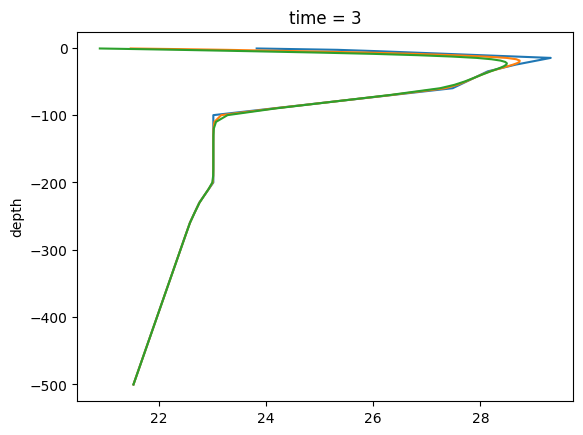

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/home/sarah/temp/ecoextreml/test/output/ZA-Kru_2023-09-06-1228_before/Sim_Temp.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_temperature = df.iloc[3:].values
soil_temperature = soil_temperature.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_t['depth'] = da_t['depth'].astype(float) * -1

da_t.isel(time=0).plot(y="depth")
da_t.isel(time=1).plot(y="depth")
da_t.isel(time=2).plot(y="depth")
# da_t.isel(time=5).plot(y="depth")
# da_t.isel(time=6).plot(y="depth")

In [17]:
da_t.isel(time=0).values

array([23.8289, 24.5803, 25.3318, 26.0832, 26.7287, 27.3742, 28.0197,
       28.6652, 29.3107, 29.1801, 29.0495, 28.919 , 28.7884, 28.6578,
       28.5272, 28.3966, 28.2661, 28.1355, 28.0049, 27.8743, 27.7437,
       27.6131, 27.4826, 26.3672, 25.2519, 24.1365, 23.0211, 23.0211,
       23.0211, 23.0211, 23.0211, 23.0211, 23.0211, 23.0211, 23.0211,
       23.0211, 23.0211, 22.9336, 22.846 , 22.7584, 22.6708, 22.5832,
       22.4957, 22.4081, 22.3205, 22.2329, 22.1453, 22.0578, 21.9702,
       21.8826, 21.795 , 21.7074, 21.6199, 21.5323])

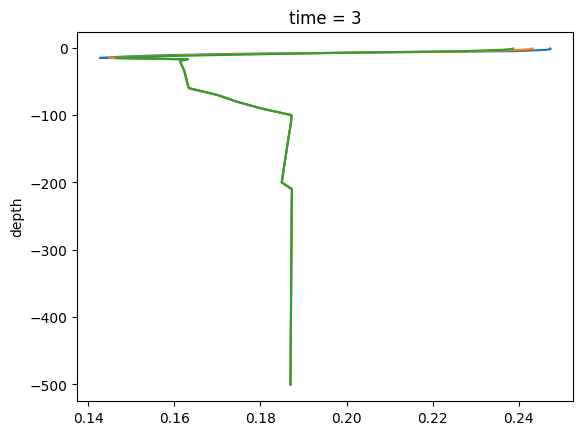

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/home/sarah/temp/ecoextreml/test/output/ZA-Kru_2023-09-06-1228_before/Sim_Theta.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_sm = df.iloc[3:].values
soil_sm = soil_sm.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_s = xr.DataArray(
    data=soil_sm,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_s['depth'] = da_s['depth'].astype(float) * -1

da_s.isel(time=0).plot(y="depth")
da_s.isel(time=1).plot(y="depth")
da_s.isel(time=2).plot(y="depth")

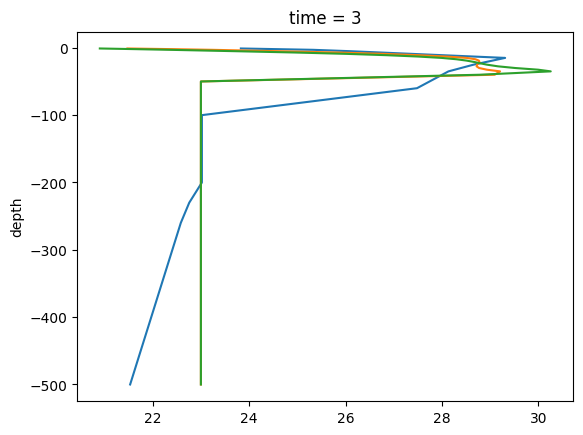

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/path_to/output/ZA-Kru_2023-09-06-1228/Sim_Temp.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values.astype(float) * -1

# Get the rest of the data as soil_temperature
soil_temperature = df.iloc[3:].values.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)

da_t.isel(time=0).plot(y="depth")
da_t.isel(time=1).plot(y="depth")
da_t.isel(time=2).plot(y="depth")

In [19]:
da_t.isel(time=0).values

array([23.8289, 24.5803, 25.3318, 26.0832, 26.7287, 27.3742, 28.0197,
       28.6652, 29.3107, 29.1801, 29.0495, 28.919 , 28.7884, 28.6578,
       28.5272, 28.3966, 28.2661, 28.1355, 28.0049, 27.8743, 27.7437,
       27.6131, 27.4826, 26.3672, 25.2519, 24.1365, 23.0211, 23.0211,
       23.0211, 23.0211, 23.0211, 23.0211, 23.0211, 23.0211, 23.0211,
       23.0211, 23.0211, 22.9336, 22.846 , 22.7584, 22.6708, 22.5832,
       22.4957, 22.4081, 22.3205, 22.2329, 22.1453, 22.0578, 21.9702,
       21.8826, 21.795 , 21.7074, 21.6199, 21.5323])

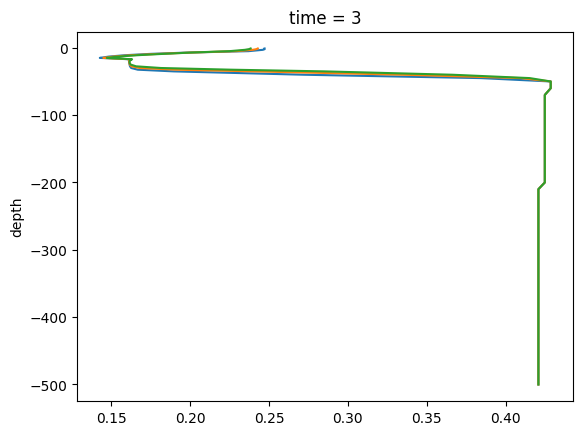

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/path_to/output/ZA-Kru_2023-09-06-1228_main/Sim_Theta.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_sm = df.iloc[3:].values
soil_sm = soil_sm.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_s = xr.DataArray(
    data=soil_sm,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_s['depth'] = da_s['depth'].astype(float) * -1

da_s.isel(time=0).plot(y="depth")
da_s.isel(time=1).plot(y="depth")
da_s.isel(time=2).plot(y="depth")

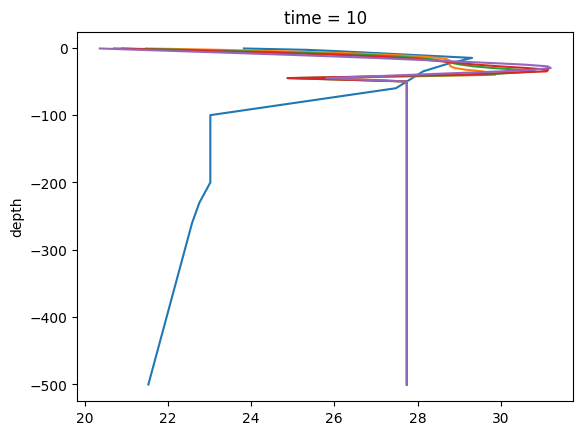

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/home/sarah/temp/ecoextreml/test/output/ZA-Kru_2023-09-06-1228/Sim_Temp.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_temperature = df.iloc[3:].values
soil_temperature = soil_temperature.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_t['depth'] = da_t['depth'].astype(float) * -1

da_t.isel(time=0).plot(y="depth")
da_t.isel(time=1).plot(y="depth")
da_t.isel(time=2).plot(y="depth")
da_t.isel(time=3).plot(y="depth")
da_t.isel(time=9).plot(y="depth")
# da_t.isel(time=19).plot(y="depth")

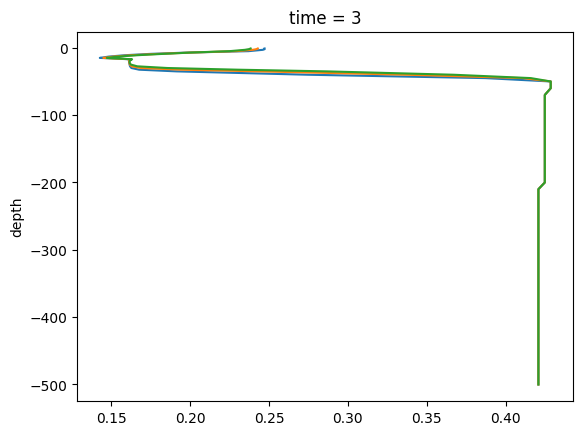

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/home/sarah/temp/ecoextreml/test/output/ZA-Kru_2023-09-06-1228/Sim_Theta.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_sm = df.iloc[3:].values
soil_sm = soil_sm.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_s = xr.DataArray(
    data=soil_sm,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_s['depth'] = da_s['depth'].astype(float) * -1

da_s.isel(time=0).plot(y="depth")
da_s.isel(time=1).plot(y="depth")
da_s.isel(time=2).plot(y="depth")
# da_s.isel(time=5).plot(y="depth")
# da_s.isel(time=9).plot(y="depth")
# da_s.isel(time=19).plot(y="depth")

In [76]:

df = pd.DataFrame({'T0': da_t.isel(time=0).values, 'T1': da_t.isel(time=1).values})

print(df)

         T0       T1
0   23.8289  21.4762
1   24.5803  22.4195
2   25.3318  23.2396
3   26.0832  24.5699
4   26.7287  25.8374
5   27.3742  26.7958
6   28.0197  27.5279
7   28.6652  28.0974
8   29.3107  28.5115
9   29.1801  28.6945
10  29.0495  28.7665
11  28.9190  28.7765
12  28.7884  28.7558
13  28.6578  28.7284
14  28.5272  28.7156
15  28.3966  28.7644
16  28.2661  28.9214
17  28.1355  29.1866
18  28.0049  29.0455
19  27.8743  24.1795
20  23.0000  23.0000
21  23.0000  23.0000
22  23.0000  23.0000
23  23.0000  23.0000
24  23.0000  23.0000
25  23.0000  23.0000
26  23.0000  23.0000
27  23.0000  23.0000
28  23.0000  23.0000
29  23.0000  23.0000
30  23.0000  23.0000
31  23.0000  23.0000
32  23.0000  23.0000
33  23.0000  23.0000
34  23.0000  23.0000
35  23.0000  23.0000
36  23.0000  23.0000
37  23.0000  23.0000
38  23.0000  23.0000
39  23.0000  23.0000
40  23.0000  23.0000
41  23.0000  23.0000
42  23.0000  23.0000
43  23.0000  23.0000
44  23.0000  23.0000
45  23.0000  23.0000
46  23.0000  

In [1]:
import xarray as xr
from pathlib import Path

# Specify the directory
dir_path = Path('/home/sarah/temp/ecoextreml/data/forcing/plumber2_data')

# Loop over the files in the directory
for file_path in dir_path.iterdir():
   
    ds_forcing = xr.open_dataset(file_path)
    print(file_path.name, ds_forcing["IGBP_veg_long"].values)

DE-Seh_2008-2010_FLUXNET2015_Met.nc b'Croplands                                                                                                                                                                                               '
AU-Gin_2012-2017_OzFlux_Met.nc b'Woody Savannas                                                                                                                                                                                          '
IT-Col_2007-2014_FLUXNET2015_Met.nc b'Deciduous Broadleaf Forests                                                                                                                                                                             '
US-GLE_2009-2014_FLUXNET2015_Met.nc b'Evergreen Needleleaf Forests                                                                                                                                                                            '
IT-LMa_2003-2004_LaThuile_Met.nc b'Deciduous 

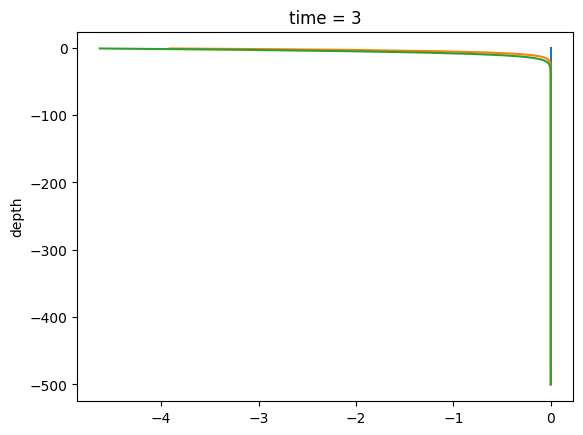

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Read the CSV file
csv_path = "/home/sarah/temp/ecoextreml/test/output/DE-Geb_2024-08-01-1043/Sim_Temp.csv"

# Read the CSV file
df = pd.read_csv(csv_path, header=None)

# Get the first row as depths
depths = df.iloc[0].values

# Get the rest of the data as soil_temperature
soil_temperature = df.iloc[3:].values
soil_temperature = soil_temperature.astype(float)

# Create a time index
time = np.arange(1, len(df)-2)

# Create the xarray DataArray
da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": time, "depth": depths},
)
da_t['depth'] = da_t['depth'].astype(float) * -1

da_t.isel(time=0).plot(y="depth")
da_t.isel(time=1).plot(y="depth")
da_t.isel(time=2).plot(y="depth")
# da_t.isel(time=3).plot(y="depth")
# da_t.isel(time=9).plot(y="depth")